In [1]:
import numpy as np
import torch
from sklearn.decomposition import PCA
from abc import ABCMeta, abstractmethod

from datasets import SynthDataset
from synth_utils import js_div, kl_div, pca
from priors import FactorizedNormalPrior

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Dataset

In [2]:
data = SynthDataset(x_dim=2, N=500, num_clusters=3, seed=0)
dataloader = torch.utils.data.DataLoader(data, batch_size=50, shuffle=True)

## Analyzing

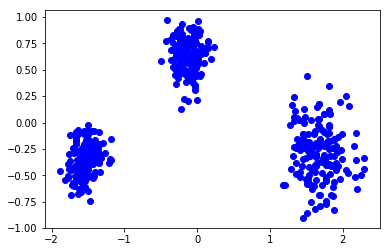

In [3]:
x = data.X.numpy()
x_r, x_f = pca(x, x)
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')

## BGAN

In [4]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)

class GeneratorNetwork(nn.Module):
    
    def __init__(self, x_dim, num_samples=1):
        super(GeneratorNetwork, self).__init__()
        self.build_net(x_dim, num_samples)
        self.output_dim = x_dim
    
    def build_net(self, x_dim, num_samples):
        z = torch.from_numpy(np.random.normal(size=[num_samples, x_dim])).float()
        self.z_v = Variable(z, requires_grad=True)
    
    
    def forward(self):
        # TODO: understand parallelism?
        output = self.z_v
        return output
    
    def parameters(self):
        return [self.z_v]

class DiscriminatorNetwork(nn.Module):
    
    def __init__(self, x_dim, K, h_dim):
        super(DiscriminatorNetwork, self).__init__()
        self.build_net(x_dim, K, h_dim)
        self.x_dim = x_dim
        self.K = K
    
    def build_net(self, x_dim, K, h_dim):
        self.network = nn.Sequential(
            nn.Linear(x_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, K),
            nn.Softmax()
        )
    
    def forward(self, input):
        # TODO: understand parallelism?
        output = self.network(input)
        return output

In [6]:
class FixedSizeDataset(torch.utils.data.Dataset):
    
    def __init__(self, maxlen):
        self.elems = []
        self.maxlen = maxlen
        
    def __getitem__(self, index):
        return self.elems[index]
    
    def append(self, elem):
        self.elems.append(elem)
        if len(self) > self.maxlen:
            self.elems = self.elems[1:]
    
    def __len__(self):
        return len(self.elems)

In [7]:
class BGAN:
    
    def __init__(self, generator, discriminator, num_data, eta=2e-4, alpha=0.01, max_fake=10000,
                disc_lr=1e-3):
        """
        Bayesian GAN with no generator
        """
        super(BGAN, self).__init__()
        
        self.discriminator = discriminator
        self.generator = generator
        
        self.x_dim = discriminator.x_dim
        self.eta = eta
        self.alpha = alpha
        self.num_data = num_data
        self.disc_lr = disc_lr
            
        self.K = discriminator.K
        self._init_optimizers()
        self.fake_dataset = FixedSizeDataset(max_fake)
        self.fake_dataset.append(np.copy(self.generator.forward().data.numpy())[0, :])
        self.fake_batch_loader = torch.utils.data.DataLoader(self.fake_dataset, 
                                                            batch_size=64, shuffle=True)
        self.fake_batch_generator = self.get_fake_batch()
        
    def get_fake_batch(self):
        while True:
            for batch in self.fake_batch_loader:
                yield Variable(batch.float())
            
    def loss(self, x_batch):
        batch_size = x_batch.size()[0]
        fake_batch = next(self.fake_batch_generator)
        x_gen = self.generator.forward()
        x_real = x_batch
        
        
        d_logits_real = self.discriminator(x_real)[:, 0]
        d_logits_fake = self.discriminator(fake_batch)[:, 0]
        d_logits_gen = self.discriminator(x_gen)[:, 0]
        
        y_real = Variable(torch.ones(batch_size))
        y_fake = Variable(torch.zeros(fake_batch.size()[0]))
        y_gen = Variable(torch.zeros(x_gen.size()[0]))
        
        bce = nn.BCELoss()
        bce_real = bce(d_logits_real, y_real)
        bce_fake = bce(d_logits_fake, y_fake)
        bce_gen = bce(d_logits_gen, y_gen)
        noise_std = np.sqrt(2 * self.alpha * self.eta)
        
        d_loss = -(bce_real + bce_fake) * self.disc_lr
        d_loss *= -1.
        
        #generator loss
        g_loss = torch.sum(torch.log(d_logits_gen[0])) * self.eta
        g_loss += self.noise(self.generator, noise_std)
        g_loss *= -1.
        self.d_loss_fake = (bce_fake).data.numpy()[0]
        self.d_loss_real = bce_real.data.numpy()[0]
        return d_loss, g_loss
        
    @staticmethod
    def noise(model, std):
        """
        Multiplies all the variables by a normal rv for SGHMC.
        """
        loss = 0
        for param in model.parameters():
            n = Variable(torch.normal(0, std=std*torch.ones(param.size())))
            loss += torch.sum(n * param)
        return loss
    
    def _init_optimizers(self):
        self.d_optimizer = optim.SGD(self.discriminator.parameters(), lr=1, momentum=(1 - self.alpha))
        self.g_optimizer = optim.SGD(self.generator.parameters(), lr=1, momentum=(1 - self.alpha))
        
    
    def step(self, x_batch):
        
        batchv = Variable(batch)
        self.discriminator.zero_grad()
        self.generator.zero_grad()
        d_loss, g_loss = self.loss(batchv)
        d_loss.backward(retain_graph=True)
        self.d_optimizer.step()
        
        g_loss.backward()
        self.g_optimizer.step()     
        

In [8]:
batch_size = 50
z_dim = 2
z = torch.rand(batch_size, z_dim)
z_var = Variable(z)

In [15]:
prior = FactorizedNormalPrior(std=10.)
gen = GeneratorNetwork(2, 1)
disc = DiscriminatorNetwork(2, 2, 100)
gen.apply(weights_init)
disc.apply(weights_init)
bgan = BGAN(gen, disc, alpha=.01, eta=1e-5, num_data=len(data), disc_lr=1e-4)
samples = []

In [21]:
def visualize(samples, x_min=None, x_max=None, y_min=None, y_max=None, with_samples=True, n_grid=500):
    min_samples = np.array((np.min(samples[:, 0]), np.min(samples[:, 1])))
    max_samples = np.array((np.max(samples[:, 0]), np.max(samples[:, 1])))
    min_x = np.array((np.min(x[:, 0]), np.min(x[:, 1])))
    max_x = np.array((np.max(x[:, 0]), np.max(x[:, 1])))
    min_ = np.min(np.vstack([min_samples[None, :], min_x[None, :]]), axis=0)
    max_ = np.max(np.vstack([max_samples[None, :], max_x[None, :]]), axis=0)
#     print(min_, max_)
#     print(np.hstack([max_samples[None, :], max_x[None, :]]))
    if x_max is None: x_max = max_[0]
    if x_min is None: x_min = min_[0]
    if y_max is None: y_max = max_[1]
    if y_min is None: y_min = min_[1]
    
    w_grid_x = np.linspace(x_min, x_max, num=n_grid)
    w_grid_y = np.linspace(y_min, y_max, num=n_grid)
    w_grid_x_, w_grid_y_ = np.meshgrid(w_grid_x, w_grid_y)
    
    w_grid_x_ = w_grid_x_.reshape(-1)[:, None]
    w_grid_y_ = w_grid_y_.reshape(-1)[:, None]
    w_grid = np.hstack([w_grid_x_, w_grid_y_])
    
    probs = disc.forward(Variable(torch.from_numpy(w_grid).float())).data.numpy()
    plt.figure(figsize=(15, 10))
    CS = plt.contour(w_grid_x, w_grid_y, (probs[:, 0]).reshape((n_grid, n_grid)))
#     print(w_grid_x)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.title('Simplest default with labels')
    plt.plot(x[:, 0], x[:, 1], 'bo', alpha=0.1)
    if with_samples:
        plt.plot(samples[:, 0], samples[:, 1], '-r')
        plt.plot(samples[-1, 0], samples[-1, 1], 'ro', markersize=10)
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])

In [41]:
if isinstance(samples, np.ndarray):
    samples = samples.tolist()
for epoch in range(1500):
    for i, data_ in enumerate(dataloader, 0):
        batch = data_.float()
        bgan.step(batch)
        samples.append(np.copy(gen.z_v.data.numpy()))
        bgan.fake_dataset.append(np.copy(gen.z_v.data.numpy()[0, :]))
    if not epoch%100:
        print(epoch)
        print(bgan.d_loss_fake)
        print(bgan.d_loss_real)
samples = np.vstack(samples)

0
0.224494
0.219341
100
0.163402
0.260224
200
0.266658
0.246332
300
0.288414
0.261874
400
0.273033
0.353646
500
0.435842
0.349997
600
0.371161
0.28727
700
0.375395
0.354875
800
0.415846
0.418758
900
0.392794
0.350007
1000
0.444022
0.416309
1100
0.380509
0.347862
1200
0.449544
0.31562
1300
0.34871
0.47697
1400
0.428733
0.446932


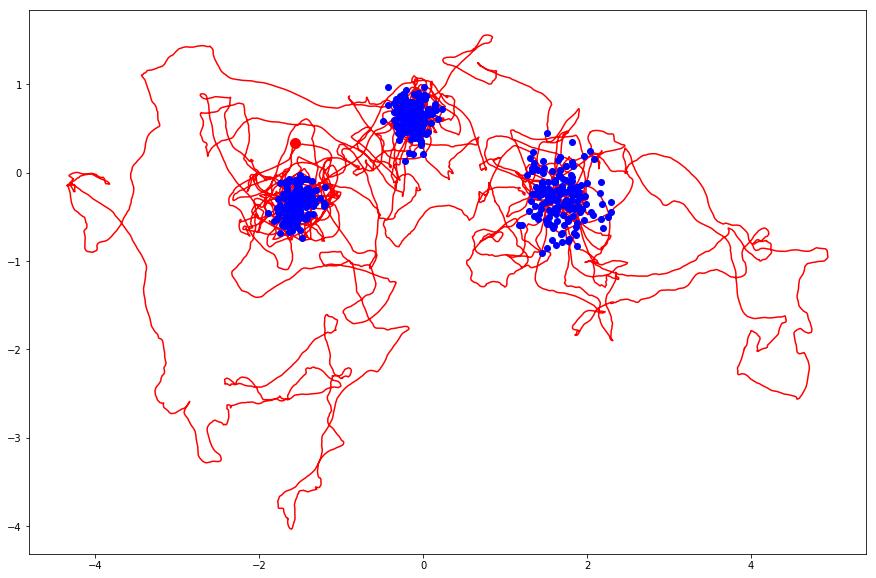

In [42]:
plt.figure(figsize=(15, 10))
x_r, x_f = pca(x, samples)
plt.plot(x_f[:, 0], x_f[:, 1], '-r')
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(x_f[-1, 0], x_f[-1, 1], 'ro', markersize=10)

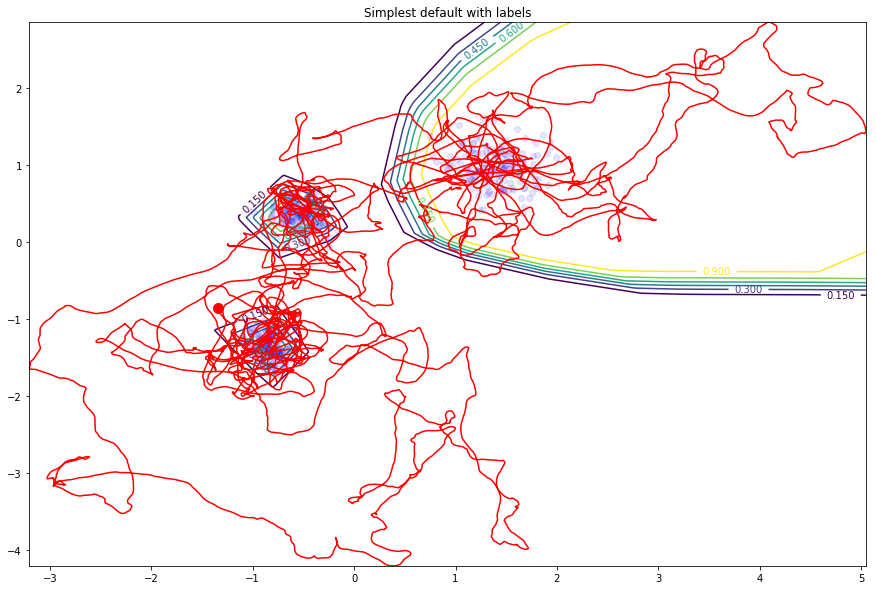

In [43]:
visualize(samples)

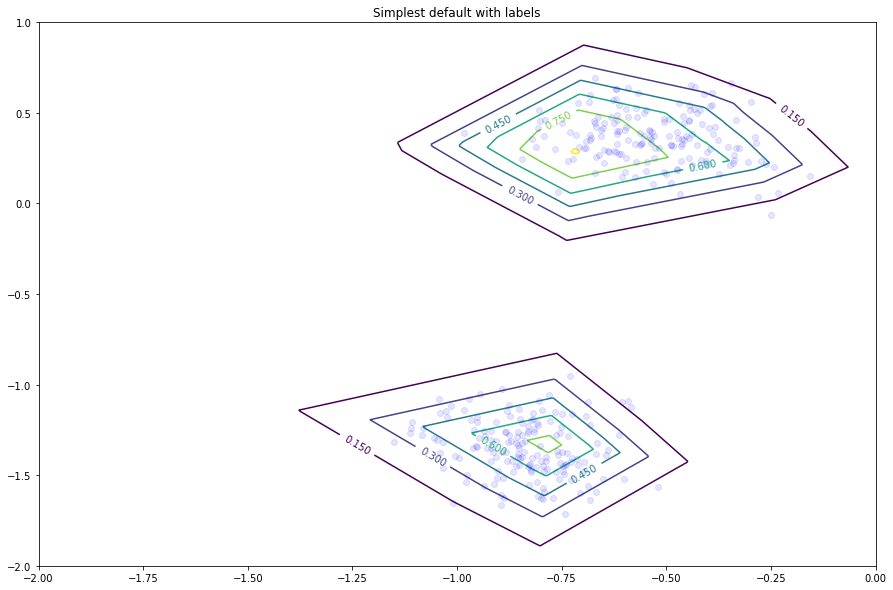

In [44]:
visualize(samples, x_min=-2., x_max=0., y_min=-2, y_max=1., with_samples=False)

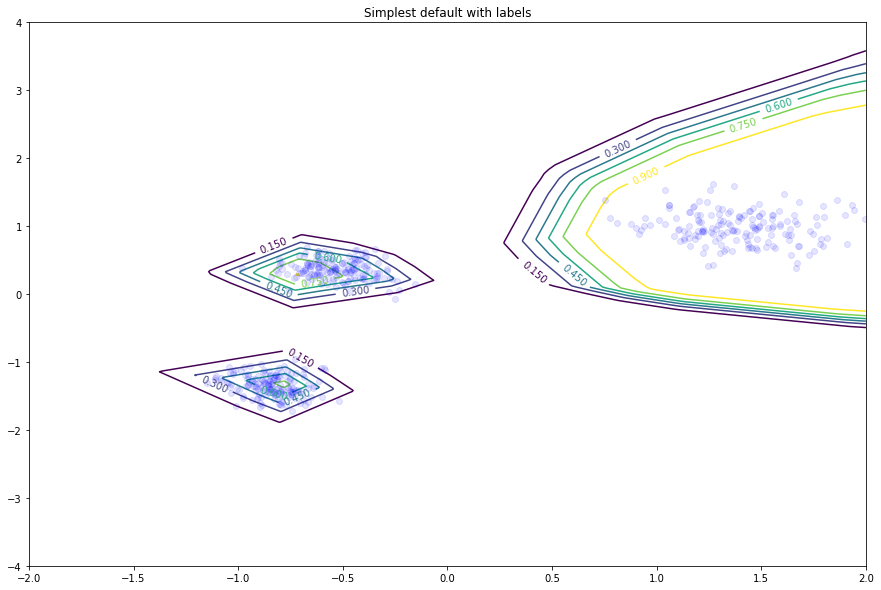

In [45]:
visualize(samples, x_min=-2, x_max=2, y_min=-4, y_max=4, with_samples=False)

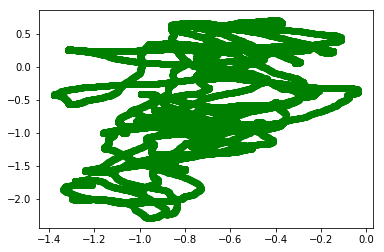

In [1383]:
fake_samples = []
for sample in bgan.fake_dataset:
    fake_samples.append(sample)
fake_samples = np.array(fake_samples)
plt.plot(fake_samples[:, 0], fake_samples[:, 1], 'go')

In [46]:
def thinning(sample_arr, freq=100):
    new_sample_arr = []
    for i, sample in enumerate(sample_arr):
        if not i % freq:
            new_sample_arr.append(sample)
    return np.array(new_sample_arr)

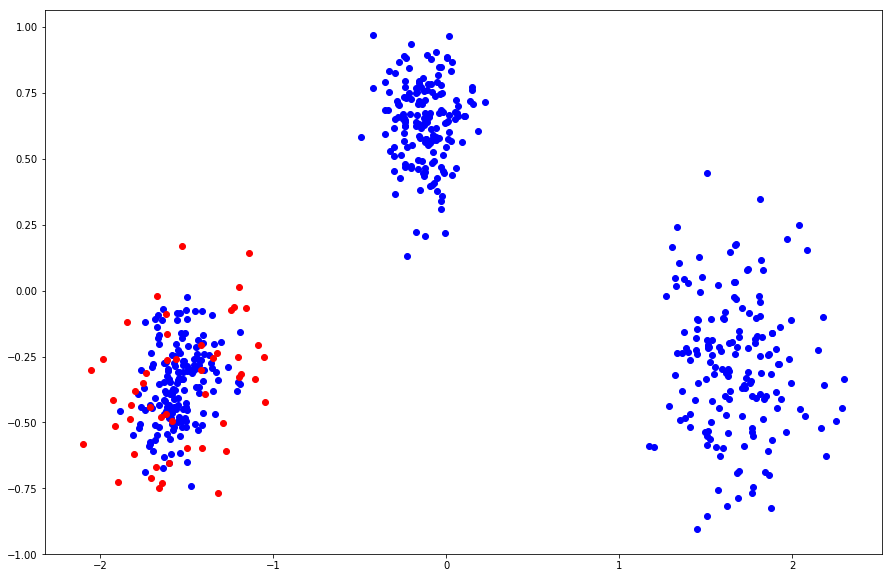

In [55]:
plt.figure(figsize=(15, 10))
thin_samples = thinning(x_f, freq=100)[-50:]
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(thin_samples[:, 0], thin_samples[:, 1], 'ro')

## Now let's try it on a high-dimensional problem

In [1488]:
x_dim = 10
data = SynthDataset(x_dim=x_dim, N=5000, num_clusters=3, seed=0)
dataloader = torch.utils.data.DataLoader(data, batch_size=50, shuffle=True)

In [1489]:
batch_size = 50
z_dim = 2
z = torch.rand(batch_size, z_dim)
z_var = Variable(z)

In [1491]:
prior = FactorizedNormalPrior(std=10.)
gen = GeneratorNetwork(x_dim, 1)
disc = DiscriminatorNetwork(x_dim, 2, 200)
gen.apply(weights_init)
disc.apply(weights_init)
bgan = BGAN(gen, disc, alpha=.1, eta=1e-5, num_data=len(data), disc_lr=1e-4)
samples = []

In [1492]:
if isinstance(samples, np.ndarray):
    samples = samples.tolist()
for epoch in range(5000):
    for i, data_ in enumerate(dataloader, 0):
        batch = data_.float()
        bgan.step(batch)
        samples.append(np.copy(gen.z_v.data.numpy()))
        bgan.fake_dataset.append(np.copy(gen.z_v.data.numpy()[0, :]))
    if not epoch%10:
        print(epoch)
        print(bgan.d_loss_fake)
        print(bgan.d_loss_real)
samples = np.vstack(samples)

0
0.628349
0.681877
10
0.184448
0.391229
20
0.0662145
0.118341
30
0.0327872
0.081087
40
0.0207549
0.0497946
50
0.0145313
0.0412279
60
0.0122208
0.0267588
70
0.0120418
0.015254
80
0.00850741
0.0128781
90
0.00482526
0.017041
100
0.0104168
0.0146886
110
0.00828932
0.0152384
120
0.0132347
0.0161883
130
0.0127731
0.0162691
140
0.0100943
0.0246002
150
0.00921801
0.0256139
160
0.01589
0.00985803
170
0.0104414
0.0104602
180
0.0102985
0.0280334
190
0.00699722
0.0306773
200
0.0175391
0.0249737
210
0.0248233
0.0465628
220
0.0202561
0.013041
230
0.0117925
0.011396
240
0.0337275
0.0529579
250
0.0362794
0.0564502
260
0.0562668
0.0271237
270
0.0257866
0.0221966
280
0.0194419
0.0200935
290
0.0264436
0.0170532
300
0.0405587
0.0157374
310
0.0198672
0.00848813
320
0.00879933
0.0126622
330
0.00670036
0.00591562
340
0.00651273
0.00481468
350
0.00324117
0.00258286
360
0.00430117
0.00225655
370
0.00319001
0.00385435
380
0.00245392
0.00231956
390
0.00246208
0.00439241
400
0.00227372
0.0019161
410
0.0049713
0.

3040
9.84698e-05
0.000360053
3050
0.000119207
0.00035369
3060
0.000179093
0.000443736
3070
6.85449e-05
0.000385805
3080
0.000133181
0.000329095
3090
0.000157512
0.000349724
3100
0.000279685
0.00030581
3110
0.000776525
0.000463692
3120
0.000620768
0.000517171
3130
0.000825208
0.00045485
3140
0.000380635
0.000397644
3150
0.000490975
0.000483752
3160
0.00049537
0.00044811
3170
0.0006949
0.000375441
3180
0.000377319
0.000532785
3190
0.000371159
0.00047249
3200
0.000248599
0.000478502
3210
0.000178457
0.000502824
3220
0.00013059
0.000397582
3230
0.000151297
0.000412088
3240
0.000128068
0.000397523
3250
0.000127397
0.000363442
3260
8.23901e-05
0.000401276
3270
4.34123e-05
0.000334561
3280
3.59761e-05
0.00039742
3290
6.76286e-05
0.000385734
3300
5.69048e-05
0.000236193
3310
0.000105802
0.000476292
3320
0.000104253
0.000297214
3330
0.000123279
0.000289254
3340
0.000242394
0.000290104
3350
0.000278976
0.000316548
3360
0.000294581
0.000325793
3370
0.000448441
0.000253424
3380
0.000374847
0.00026

KeyboardInterrupt: 

In [1495]:
samples.shape

(419126, 10)

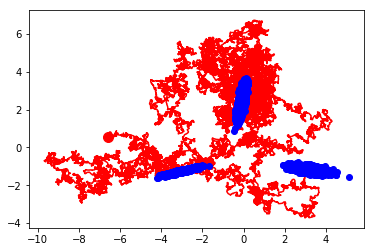

In [1496]:
x_r, x_f = pca(data.X.numpy(), samples)
plt.plot(x_f[:, 0], x_f[:, 1], '-r')
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(x_f[-1, 0], x_f[-1, 1], 'ro', markersize=10)

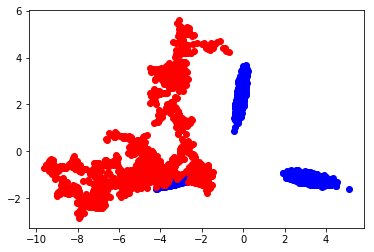

In [1500]:
thin_samples = thinning(x_f, 100)[3000:]
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(thin_samples[:, 0], thin_samples[:, 1], 'ro')

In [ ]:
x_r, x_f = pca(data.X.numpy(), samples)
plt.plot(x_f[:, 0], x_f[:, 1], '-r')
plt.plot(x_r[:, 0], x_r[:, 1], 'bo')
plt.plot(x_f[-1, 0], x_f[-1, 1], 'ro', markersize=10)